In [1]:
from os import scandir, getcwd
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def prepare_images(ruta,inception):
  Y = []
  X = []
  X_inc = []
  for a in scandir(ruta):
    #encoder
    image = img_to_array(load_img(ruta+""+a.name, target_size=(256,256))) / 255
    lab_image = rgb2lab(image)
    lab_image_norm = (lab_image + [0, 128, 128]) / [100, 255, 255]
    #the source will be the image in white and black together to inception vector of 1000 dl
    x_encoder = lab_image_norm[:,:,0]
    # Outputs are corresponded with ab channel
    y_encoder = lab_image_norm[:,:,1:]

    #inception
    image_inception = img_to_array(load_img(ruta+""+a.name, target_size=(299,299))) / 255
    image_inception = rgb2gray(image_inception)
    #we give inception 3 same channels in grey
    image_inception = gray2rgb(image_inception)
    image_inception_norm = image_inception.reshape(1,299,299,3)
    x_inception = inception.predict(image_inception_norm)

    X.append(x_encoder)
    Y.append(y_encoder)
    X_inc.append(x_inception[0])
    
  X = np.array(X)
  Y = np.array(Y)
  X_inc = np.array(X_inc)
  return X, X_inc, Y

In [2]:
import pickle
"""Load inception model """

inception = InceptionResNetV2(weights="imagenet", include_top=True)

"""  Data  """
X, X_inc, Y = prepare_images('/content/drive/MyDrive/MASTER/fruit/train/',inception)

with open("obj.pickle", "wb") as f:
    pickle.dump([X,X_inc,Y], f)

225214464/225209952 [==============================] - 5s 0us/step


In [3]:
"""Creating a model with 2 sources, a image with a size of 256x256 to encoder-decoder
 and the other source is a vector with a size of 1000 to Inception"""

embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)


"""Compile and train"""

model.compile(optimizer='adam', loss='mse')
model.fit([X,X_inc],Y, epochs=50 ,steps_per_epoch=5)


Epoch 1/50
5/5 [==============================] - 104s 14s/step - loss: 0.2407
Epoch 2/50
5/5 [==============================] - 15s 3s/step - loss: 0.1106
Epoch 3/50
5/5 [==============================] - 15s 3s/step - loss: 0.0278
Epoch 4/50
5/5 [==============================] - 15s 3s/step - loss: 0.0195
Epoch 5/50
5/5 [==============================] - 15s 3s/step - loss: 0.0141
Epoch 6/50
5/5 [==============================] - 15s 3s/step - loss: 0.0122
Epoch 7/50
5/5 [==============================] - 15s 3s/step - loss: 0.0116
Epoch 8/50
5/5 [==============================] - 15s 3s/step - loss: 0.0111
Epoch 9/50
5/5 [==============================] - 15s 3s/step - loss: 0.0105
Epoch 10/50
5/5 [==============================] - 15s 3s/step - loss: 0.0097
Epoch 11/50
5/5 [==============================] - 15s 3s/step - loss: 0.0090
Epoch 12/50
5/5 [==============================] - 15s 3s/step - loss: 0.0087
Epoch 13/50
5/5 [==============================] - 15s 3s/step - loss: 

In [4]:
X_test, X_inc_test, Y_test = prepare_images('/content/drive/MyDrive/MASTER/fruit/test/',inception)

In [5]:
"""Testing the model"""
from matplotlib.pyplot import imshow
ccc = model.evaluate([X_test,X_inc_test],Y_test)
print(ccc)
outputs = model.predict([X_test,X_inc_test])


3/3 [==============================] - 15s 3s/step - loss: 0.0027
0.002653463277965784


######IMAGEN ORIGINAL########


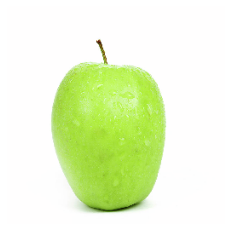

In [99]:
num= 5
X_prueba = X_test[num]
X_prueba = X_prueba.reshape(1, 256, 256, 1)
X_prueba.shape
print("######IMAGEN ORIGINAL########")
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X_prueba[0][:,:,0]
cur[:,:,1:] = Y_test[num]
cur = (cur * [100, 255, 255]) - [0, 128, 128]
rgb_image = lab2rgb(cur)
plt.axis('off')
imshow(rgb_image)


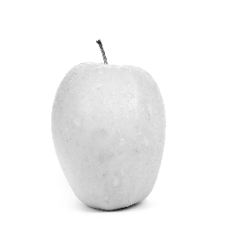

In [100]:
#GREY scale image
plt.axis('off')
imshow(X_prueba[0][:,:,0],cmap=plt.cm.gray)

######IMAGEN COLOREADA########


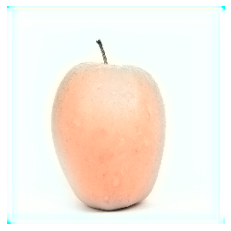

In [101]:
#generated image
print("######IMAGEN COLOREADA########")
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X_prueba[0][:,:,0]
cur[:,:,1:] = outputs[num]
cur = (cur * [100, 255, 255]) - [0, 128, 128]
rgb_image = lab2rgb(cur)
plt.axis('off')
imshow(rgb_image)